# Notes on Chapter 3 of *Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow* by Aurélien Géron

Import the MNIST dataset

In [1]:
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
print(mnist['DESCR'])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
X = mnist['data']
y = mnist['target']
print(f'{X.shape} {y.shape}')

(70000, 784) (70000,)


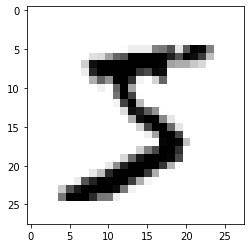

In [6]:
from matplotlib import pyplot as plt
plt.imshow(X[0].reshape((28,28)), cmap='binary')
plt.show()

In [7]:
y[0]

'5'

Split the data into testing and training data

In [8]:
size_train = 60000
X_train = X[:size_train]
X_test = X[size_train:]
y_train = y[:size_train].astype(np.uint8)
y_test = y[size_train:].astype(np.uint8)

Start with the binary test "is this a 5"

In [9]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5
print(f'{sum(y_train_5)} {sum(y_test_5)}')

5421 892


Train an SGD classifier

In [10]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=1811, max_iter=1000, tol=1e-3)
sgd.fit(X_train, y_train_5)

SGDClassifier(random_state=1811)

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train_5, cv=10, scoring="accuracy", n_jobs=10)

array([0.96733333, 0.90666667, 0.93116667, 0.96583333, 0.94866667,
       0.9585    , 0.967     , 0.9675    , 0.96716667, 0.95866667])

Compare with a "dumb" classifier

In [12]:
from sklearn.base import BaseEstimator

class NeverFive(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((X.shape[0], 1))
    
cross_val_score(NeverFive(), X_train, y_train_5, cv=10, scoring="accuracy")

array([0.91433333, 0.911     , 0.91016667, 0.90716667, 0.90583333,
       0.91316667, 0.90766667, 0.91      , 0.90866667, 0.9085    ])

In [13]:
from sklearn.model_selection import cross_val_predict
yhat_train_5 = cross_val_predict(sgd, X_train, y_train_5, cv=10, n_jobs=10)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, yhat_train_5)

array([[53133,  1446],
       [ 1323,  4098]])

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'precison: {precision_score(y_train_5, yhat_train_5)} recall:{recall_score(y_train_5, yhat_train_5)} F:{f1_score(y_train_5, yhat_train_5)}')

precison: 0.7391774891774892 recall:0.7559490868843387 F:0.747469220246238


In [16]:
a_train_5 = cross_val_predict(sgd, X_train, y_train_5, cv=10, n_jobs=10, method='decision_function')

In [17]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, a_train_5)

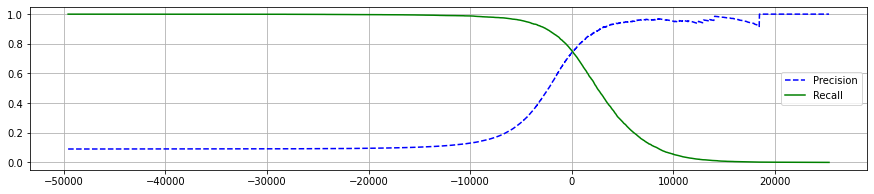

In [18]:
fig,ax = plt.subplots(figsize=(15,3))

ax.plot(thresholds, precisions[:-1], 'b--', label='Precision')
ax.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.grid(True)
plt.legend()

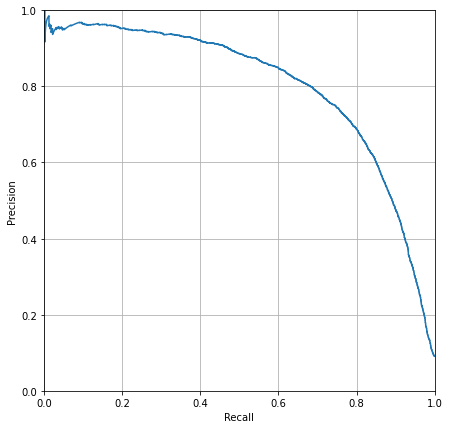

In [19]:
fig,ax = plt.subplots(figsize=(7,7))

ax.plot(recalls, precisions)
ax.set(xlabel='Recall', ylabel='Precision', xlim=(0,1), ylim=(0,1))
plt.grid(True)
#plt.legend()

In [20]:
threshold_90_precision = thresholds[precisions[1:] >= 0.9][0]

In [21]:
threshold_90_precision

2811.9031505832945

In [22]:
precision_score(y_train_5, a_train_5 > threshold_90_precision)

0.9

In [23]:
recall_score(y_train_5, a_train_5 > threshold_90_precision)

0.47149972329828443

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_train_5, a_train_5)

Text(0.5, 1.0, 'ROC AUC: 0.956')

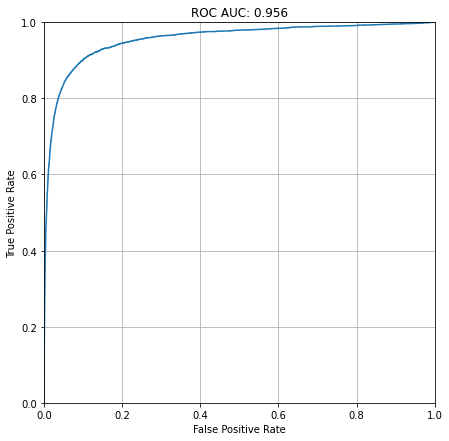

In [25]:
fig,ax = plt.subplots(figsize=(7,7))

ax.plot(fpr, tpr)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', xlim=(0,1), ylim=(0,1))
plt.grid(True)
plt.title(f'ROC AUC: {roc_auc_score(y_train_5, a_train_5):.3f}')
#plt.legend()

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1811)
a_train_5_rf = cross_val_predict(rf, X_train, y_train_5, cv=10, n_jobs=10, method='predict_proba')[:,1]

In [27]:
a_train_5_rf

array([0.88, 0.01, 0.  , ..., 0.99, 0.13, 0.09])

In [28]:
fpr_rf, tpr_rf, threholds_rf = roc_curve(y_train_5, a_train_5_rf)

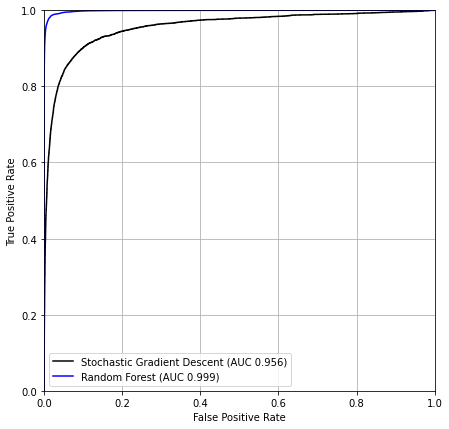

In [29]:
fig,ax = plt.subplots(figsize=(7,7))

ax.plot(fpr, tpr, color='black', label=f"Stochastic Gradient Descent (AUC {roc_auc_score(y_train_5, a_train_5):.3f})")
ax.plot(fpr_rf, tpr_rf, color='blue', label=f"Random Forest (AUC {roc_auc_score(y_train_5, a_train_5_rf):.3f})")
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', xlim=(0,1), ylim=(0,1))
plt.grid(True)
plt.legend()

In [30]:
precision_score(y_train_5, a_train_5_rf > 0.5)

0.9896114689382921

In [31]:
recall_score(y_train_5, a_train_5_rf > 0.5)

0.8786201807784542

Train a Support vector classifier on all of the different classes

In [70]:
from sklearn.svm import SVC
svc = SVC(gamma='scale', max_iter=10, tol=1)
%timeit -n1 -r1 svc.fit(X_train, y_train) 

10.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/kms15/jupyter/jupyter_venv/lib/python3.6/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [71]:
svc.predict([X[0]])

array([5], dtype=uint8)

In [72]:
svc.decision_function([X[0]])

array([[3.85978806, 3.94038316, 6.07623925, 7.18280266, 0.82077838,
        9.20726551, 1.89269745, 3.89629817, 7.09902464, 0.88248071]])

In [73]:
svc.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Manually force it to use a one vs. rest classifier instead of one vs one

In [69]:
from sklearn.multiclass import OneVsRestClassifier
ovr_svr = OneVsRestClassifier(SVC(gamma='scale', max_iter=10, tol=1))
%timeit -n1 -r1 ovr_svr.fit(X_train, y_train) 

/home/kms15/jupyter/jupyter_venv/lib/python3.6/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/kms15/jupyter/jupyter_venv/lib/python3.6/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/kms15/jupyter/jupyter_venv/lib/python3.6/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/kms15/jupyter/jupyter_venv/lib/python3.6/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.ma

15.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/kms15/jupyter/jupyter_venv/lib/python3.6/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [63]:
ovr_svr.decision_function([X[0]])

array([[-0.26586084, -0.47378672, -0.13430171,  0.05343195, -0.49325214,
         0.21931762, -0.46694369, -0.08599549, -0.12187363, -0.25344717]])

Train a stochastic gradient descent model on all classes

In [75]:
sgd = SGDClassifier(random_state=1811, max_iter=1000, tol=1e-3)
sgd.fit(X_train, y_train)

SGDClassifier(random_state=1811)

In [76]:
sgd.decision_function([X[0]])

array([[-18597.91263309, -25024.81881254,  -9161.91543996,
          -706.67559268, -21559.56573357,    746.68218534,
        -31440.62979448, -21771.55517166, -11544.49923114,
        -16663.38455241]])

In [79]:
cross_val_score(sgd, X_train, y_train, cv=10, scoring="accuracy", n_jobs=10)

array([0.87583333, 0.86866667, 0.856     , 0.87683333, 0.87566667,
       0.87466667, 0.8805    , 0.866     , 0.8645    , 0.86533333])

Try adding scaling to see if we can improve this score

In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaled_sgd = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(random_state=1811, max_iter=1000, tol=1e-3))
])

cross_val_score(scaled_sgd, X_train, y_train, cv=10, scoring="accuracy", n_jobs=10)

array([0.89833333, 0.89583333, 0.88483333, 0.89916667, 0.90033333,
       0.88516667, 0.88133333, 0.89333333, 0.88433333, 0.91966667])

In [84]:
yhat_train = cross_val_predict(scaled_sgd, X_train, y_train, cv=10, n_jobs=40)

In [86]:
cm = confusion_matrix(y_train, yhat_train)
cm

array([[5566,    0,   16,    5,    7,   37,   31,    5,  255,    1],
       [   0, 6398,   43,   22,    3,   41,    4,    6,  216,    9],
       [  23,   26, 5217,   86,   67,   21,   63,   40,  407,    8],
       [  25,   16,  110, 5175,    1,  177,   25,   40,  498,   64],
       [  11,   12,   40,    9, 5166,    9,   33,   17,  397,  148],
       [  22,   16,   26,  146,   49, 4397,   79,   14,  611,   61],
       [  25,   16,   42,    2,   39,   85, 5547,    6,  156,    0],
       [  18,   11,   49,   17,   52,   11,    4, 5674,  236,  193],
       [  14,   62,   40,   91,    2,  115,   27,    8, 5456,   36],
       [  20,   19,   31,   56,  117,   35,    1,  163,  449, 5058]])

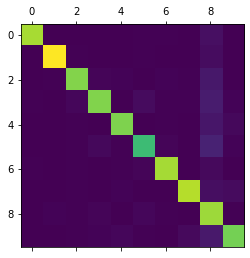

In [87]:
plt.matshow(cm)
plt.show()

In [88]:
row_sums = cm.sum(axis=1, keepdims=True)
norm_cm = cm / row_sums

In [89]:
errors = norm_cm.copy()
np.fill_diagonal(errors, 0)

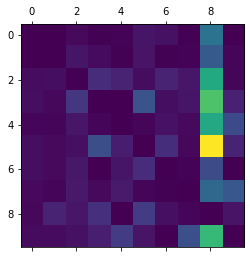

In [90]:
plt.matshow(errors)
plt.show()

Create a dataset with multiple non-disjoint labels

In [95]:
y_train_large = y_train >= 7
y_train_odd = y_train % 2 != 0
y_train_largely_odd = np.c_[y_train_large, y_train_odd]

Train a $k$-nearest neighbors classifier

In [96]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train_largely_odd)

KNeighborsClassifier()

In [97]:
knn.predict([X[0]])

array([[False,  True]])

In [99]:
yhat_train_knn = cross_val_predict(knn, X_train, y_train_largely_odd, cv=10, n_jobs=10)

In [102]:
f1_score(y_train_largely_odd, yhat_train_knn, average="macro")

0.9781882056522759

"Multioutput classification" example (uses image denoising, so arguably more of a regression problem but we'll ignore the ordering and distance metrics of the integer pixel intensities and treat each value as an independent catagory.

In [108]:
X_train_noisy = X_train + np.random.randint(0, 100, X_train.shape)

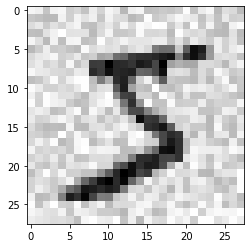

In [109]:
plt.imshow(X_train_noisy[0].reshape((28,28)), cmap='binary')
plt.show()

In [111]:
Xhat_train_noisy_knn = cross_val_predict(knn, X_train_noisy, X_train, cv=10, n_jobs=10)

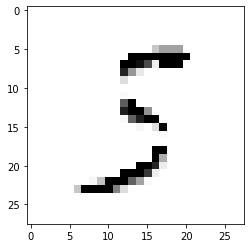

In [113]:
plt.imshow(Xhat_train_noisy_knn[0].reshape((28,28)), cmap='binary')
plt.show()

## Exercises

### 1: Better MNIST classifier

In [114]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': [2, 3, 5, 8]},
]

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy", return_train_score=True, n_jobs=84)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=84,
             param_grid=[{'n_neighbors': [2, 3, 5, 8],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='accuracy')

In [115]:
grid_search.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [116]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [117]:
cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=10, scoring="accuracy", n_jobs=10)

array([0.97583333, 0.9695    , 0.9715    , 0.975     , 0.97116667,
       0.97216667, 0.9725    , 0.97066667, 0.96633333, 0.97766667])

### 2: Data augmentation by shifting MNIST image by 1 pixel

In [176]:
from scipy.ndimage.interpolation import shift
from sklearn.base import BaseEstimator, TransformerMixin

class MNISTImageShiftedEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator
    
    def fit(self, X, y=None):
        X_reshaped = X.reshape((-1,28,28))
        X_augmented_reshaped = np.concatenate([
            shift(X_reshaped, [0,i,j], order=0)
                for i in range(-1,2)
                for j in range(-1,2)
        ])
        X_augmented = X_augmented_reshaped.reshape((-1, X.shape[1]))
        y_augmented = np.tile(y, 9)
        self.estimator.fit(X_augmented, y_augmented)
        return self
    
    def transform(self, X, y=None):
        return self.estimator.transform(X, y)
    
    def predict(self, X):
        return self.estimator.predict(X)


In [188]:
shifted_knn = MNISTImageShiftedEstimator(KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='ball_tree'))

In [190]:
cross_val_score(shifted_knn, X_train, y_train, cv=10, scoring="accuracy", n_jobs=10)

array([0.98066667, 0.978     , 0.98      , 0.98383333, 0.9765    ,
       0.98033333, 0.9805    , 0.977     , 0.976     , 0.98166667])

### 3: Titanic dataset

In [191]:
import pandas as pd
import numpy as np

original_data = pd.read_csv('data/titanic.csv')
y_all = original_data['Survived']
X_all = original_data.drop(['Survived'], axis=1)

In [192]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In [193]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

full_model = Pipeline([
    ('preprocessing', ColumnTransformer([
        ('onehot', OneHotEncoder(), ['Pclass', 'Sex']),
        ('scaler', StandardScaler(), ['Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare'])
        ], remainder='drop'
    )),
    ('rf', RandomForestClassifier())
])

In [194]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(full_model, X_train, y_train, cv=10, scoring="accuracy", n_jobs=10)
print(f'accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

accuracy: 0.818 +/- 0.044


In [195]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'rf__n_estimators': [200,300,500,800,1300], 
     'rf__max_features':[None, 'sqrt', 'log2'],
     'rf__max_depth':[None,3,5,8,13]
    },
]

grid_search = GridSearchCV(full_model, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True, n_jobs=4*3*5)
grid_search.fit(X_train, y_train);

In [196]:
scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=10, scoring="accuracy", n_jobs=10)
print(f'accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

accuracy: 0.838 +/- 0.047


In [197]:
grid_search.best_params_

{'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}

### 4: Spam Assassin dataset

In [296]:
from pathlib import Path
import numpy as np

def read_spamassassin_files(path):
    def filename_to_contents(filename):
        with open(filename, 'rb') as f:
            return f.read()
    filenames = list(Path(path).glob('0*'))
    return [filename_to_contents(filename) for filename in filenames]

In [297]:
spam_paths = ['data/spamassassin/spam/','data/spamassassin/spam_2/']
ham_paths = ['data/spamassassin/easy_ham/', 'data/spamassassin/easy_ham_2/', 'data/spamassassin/hard_ham/']

In [298]:
X_spam = np.concatenate([read_spamassassin_files(path) for path in spam_paths])
X_ham = np.concatenate([read_spamassassin_files(path) for path in ham_paths])

In [299]:
y_spam = np.ones(len(X_spam), dtype=int)
y_ham = np.zeros(len(X_ham), dtype=int)

In [300]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.concatenate((X_spam, X_ham)), np.concatenate((y_spam, y_ham)), test_size=0.2, random_state=42)

In [301]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(decode_error='replace', max_features=2000)),
    ('rf', RandomForestClassifier())
])

#scores = cross_val_score(rf_pipeline, X_train, y_train, cv=10, scoring="accuracy", n_jobs=10)
#print(f'accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

In [302]:
from sklearn.model_selection import cross_val_predict

a_train = cross_val_predict(rf_pipeline, X_train, y_train, cv=10, n_jobs=10, method='predict_proba')[:,1]

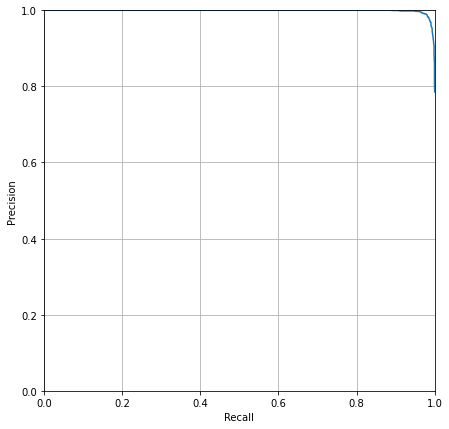

In [303]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_train, a_train)

fig,ax = plt.subplots(figsize=(7,7))

ax.plot(recalls, precisions)
ax.set(xlabel='Recall', ylabel='Precision', xlim=(0,1), ylim=(0,1))
plt.grid(True)
#plt.legend()

Text(0.5, 1.0, 'ROC AUC: 0.999')

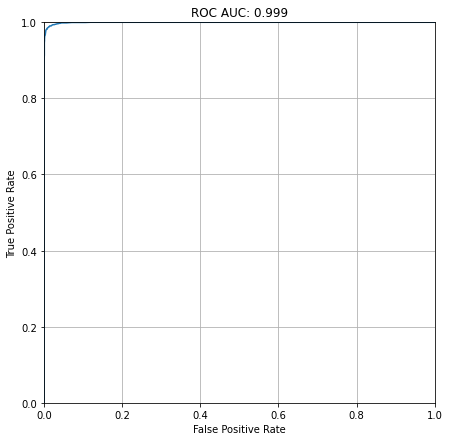

In [304]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_train, a_train)

fig,ax = plt.subplots(figsize=(7,7))

ax.plot(fpr, tpr)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', xlim=(0,1), ylim=(0,1))
plt.grid(True)
plt.title(f'ROC AUC: {roc_auc_score(y_train, a_train):.3f}')

In [305]:
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(decode_error='replace', max_features=2000)),
    ('lr', LogisticRegression(tol=0.01, solver='saga', C=0.1))
])

#scores = cross_val_score(rf_pipeline, X_train, y_train, cv=10, scoring="accuracy", n_jobs=10)
#print(f'accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

In [306]:
from sklearn.model_selection import cross_val_predict

lr_a_train = cross_val_predict(lr_pipeline, X_train, y_train, cv=10, n_jobs=10, method='predict_proba')[:,1]

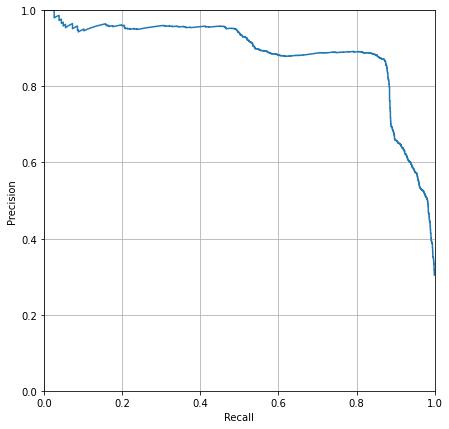

In [307]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_train, lr_a_train)

fig,ax = plt.subplots(figsize=(7,7))

ax.plot(recalls, precisions)
ax.set(xlabel='Recall', ylabel='Precision', xlim=(0,1), ylim=(0,1))
plt.grid(True)
#plt.legend()

Text(0.5, 1.0, 'ROC AUC: 0.944')

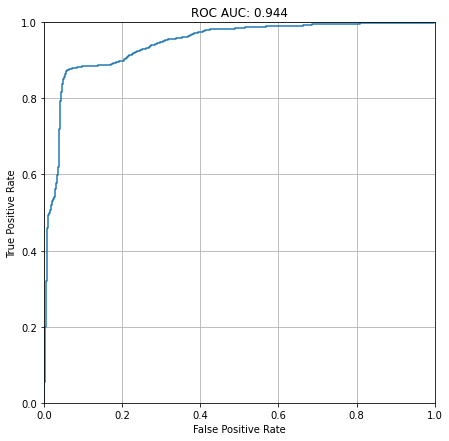

In [308]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_train, lr_a_train)

fig,ax = plt.subplots(figsize=(7,7))

ax.plot(fpr, tpr)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', xlim=(0,1), ylim=(0,1))
plt.grid(True)
plt.title(f'ROC AUC: {roc_auc_score(y_train, lr_a_train):.3f}')

In [309]:
from sklearn.neighbors import KNeighborsClassifier

lr_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(decode_error='replace', max_features=2000)),
    ('knn', KNeighborsClassifier(n_neighbors=8, weights='distance'))
])

#scores = cross_val_score(rf_pipeline, X_train, y_train, cv=10, scoring="accuracy", n_jobs=10)
#print(f'accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

In [310]:
knn_a_train = cross_val_predict(lr_pipeline, X_train, y_train, cv=10, n_jobs=10, method='predict_proba')[:,1]

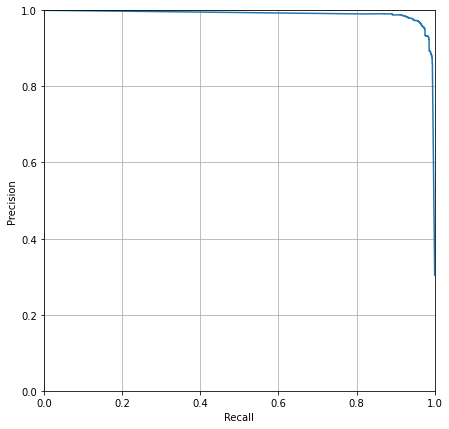

In [311]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_train, knn_a_train)

fig,ax = plt.subplots(figsize=(7,7))

ax.plot(recalls, precisions)
ax.set(xlabel='Recall', ylabel='Precision', xlim=(0,1), ylim=(0,1))
plt.grid(True)
#plt.legend()

Text(0.5, 1.0, 'ROC AUC: 0.994')

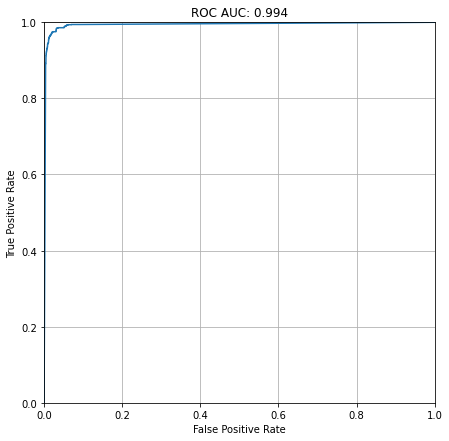

In [312]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_train, knn_a_train)

fig,ax = plt.subplots(figsize=(7,7))

ax.plot(fpr, tpr)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', xlim=(0,1), ylim=(0,1))
plt.grid(True)
plt.title(f'ROC AUC: {roc_auc_score(y_train, knn_a_train):.3f}')